In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load TensorBoard
%load_ext tensorboard

In [2]:
# Convert from 64 to 32 bit floats
X_test = np.load("../data/X_test.npy").astype(np.float32)
y_test = np.load("../data/y_test.npy").astype(np.float32)
person_train_valid = np.load("../data/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("../data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("../data/y_train_valid.npy").astype(np.float32)
person_test = np.load("../data/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


## Whiten data
Ignored for now, signals seem pretty zero centered already

In [3]:
# X_train_valid -= np.mean(X_train_valid, axis=-1).reshape((X_train_valid.shape[0], X_train_valid.shape[1], 1))
# X_test -= np.mean(X_test, axis=-1).reshape((X_test.shape[0], X_test.shape[1], 1))

In [4]:
# plt.figure(figsize=(16,40))
# for i in range(X_train_valid.shape[1]):
#     plt.subplot(X_train_valid.shape[1]//3+1, 3, i+1)
#     plt.plot(X_train_valid[0,i,:])
#     plt.title("Channel %d" % (i+1))
# plt.show()

# Convert to TensorFlow data structure
Reference: https://www.tensorflow.org/tutorials/load_data/numpy

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid, y_train_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

print(train_dataset.element_spec)
print(test_dataset.element_spec)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

(TensorSpec(shape=(22, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
(TensorSpec(shape=(22, 1000), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))


In [6]:
model = tf.keras.Sequential()
model.add(layers.Reshape((1, 22, 1000), input_shape=(22, 1000)))
model.add(layers.Conv2D(input_shape=(1, 22, 1000),
                        filters=40, kernel_size=(1, 25), data_format='channels_first',
                        activation='relu', kernel_regularizer='l2'))
model.add(layers.Permute((3, 1, 2)))
model.add(layers.Reshape((976, 880)))
model.add(layers.Dropout(0.25, noise_shape=(1, 880)))
model.add(layers.Dense(40, kernel_regularizer='l2'))
# model.add(layers.ReLU())
model.add(layers.Lambda(lambda x: K.pow(x, 2)))
model.add(layers.AveragePooling1D(input_shape=(976, 880),
                                  pool_size=75, strides=15))
model.add(layers.Lambda(lambda x: K.log(x)))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax', kernel_regularizer='l2',
                       kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 22, 1000)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 22, 976)       1040      
_________________________________________________________________
permute (Permute)            (None, 976, 40, 22)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 976, 880)          0         
_________________________________________________________________
dropout (Dropout)            (None, 976, 880)          0         
_________________________________________________________________
dense (Dense)                (None, 976, 40)           35240     
_________________________________________________________________
lambda (Lambda)              (None, 976, 40)           0

Epoch 1/300
34/34 [==============================] - 4s 122ms/step - loss: 2.3925 - sparse_categorical_accuracy: 0.2421 - val_loss: 2.0958 - val_sparse_categorical_accuracy: 0.2889
Epoch 2/300
34/34 [==============================] - 1s 28ms/step - loss: 2.0970 - sparse_categorical_accuracy: 0.3050 - val_loss: 2.0942 - val_sparse_categorical_accuracy: 0.2754
Epoch 3/300
34/34 [==============================] - 1s 27ms/step - loss: 2.0082 - sparse_categorical_accuracy: 0.3272 - val_loss: 1.9716 - val_sparse_categorical_accuracy: 0.3093
Epoch 4/300
34/34 [==============================] - 1s 28ms/step - loss: 1.8972 - sparse_categorical_accuracy: 0.3593 - val_loss: 1.9098 - val_sparse_categorical_accuracy: 0.3702
Epoch 5/300
34/34 [==============================] - 1s 28ms/step - loss: 1.8338 - sparse_categorical_accuracy: 0.3655 - val_loss: 1.7423 - val_sparse_categorical_accuracy: 0.3905
Epoch 6/300
34/34 [==============================] - 1s 27ms/step - loss: 1.8199 - sparse_categoric

34/34 [==============================] - 1s 27ms/step - loss: 0.8755 - sparse_categorical_accuracy: 0.7253 - val_loss: 1.2901 - val_sparse_categorical_accuracy: 0.5508
Epoch 47/300
34/34 [==============================] - 1s 27ms/step - loss: 0.8595 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.2608 - val_sparse_categorical_accuracy: 0.5801
Epoch 48/300
34/34 [==============================] - 1s 27ms/step - loss: 0.8423 - sparse_categorical_accuracy: 0.7475 - val_loss: 1.2613 - val_sparse_categorical_accuracy: 0.5734
Epoch 49/300
34/34 [==============================] - 1s 27ms/step - loss: 0.8439 - sparse_categorical_accuracy: 0.7418 - val_loss: 1.2735 - val_sparse_categorical_accuracy: 0.5756
Epoch 50/300
34/34 [==============================] - 1s 27ms/step - loss: 0.9221 - sparse_categorical_accuracy: 0.7026 - val_loss: 1.2694 - val_sparse_categorical_accuracy: 0.5553
Epoch 51/300
34/34 [==============================] - 1s 25ms/step - loss: 0.8463 - sparse_categorical_accur

34/34 [==============================] - 1s 27ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.8402 - val_loss: 1.4051 - val_sparse_categorical_accuracy: 0.5621
Epoch 92/300
34/34 [==============================] - 1s 27ms/step - loss: 0.7507 - sparse_categorical_accuracy: 0.7981 - val_loss: 1.3381 - val_sparse_categorical_accuracy: 0.5779
Epoch 93/300
34/34 [==============================] - 1s 27ms/step - loss: 0.8208 - sparse_categorical_accuracy: 0.7697 - val_loss: 1.4768 - val_sparse_categorical_accuracy: 0.5463
Epoch 94/300
34/34 [==============================] - 1s 27ms/step - loss: 0.7344 - sparse_categorical_accuracy: 0.8085 - val_loss: 1.4878 - val_sparse_categorical_accuracy: 0.5734
Epoch 95/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6816 - sparse_categorical_accuracy: 0.8322 - val_loss: 1.3671 - val_sparse_categorical_accuracy: 0.6027
Epoch 96/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6917 - sparse_categorical_accur

34/34 [==============================] - 1s 26ms/step - loss: 0.6801 - sparse_categorical_accuracy: 0.8402 - val_loss: 1.4965 - val_sparse_categorical_accuracy: 0.5959
Epoch 137/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.8534 - val_loss: 1.5078 - val_sparse_categorical_accuracy: 0.5824
Epoch 138/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.8643 - val_loss: 1.4508 - val_sparse_categorical_accuracy: 0.5756
Epoch 139/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.8520 - val_loss: 1.4311 - val_sparse_categorical_accuracy: 0.5643
Epoch 140/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5762 - sparse_categorical_accuracy: 0.9012 - val_loss: 1.4546 - val_sparse_categorical_accuracy: 0.5869
Epoch 141/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6220 - sparse_categorical_

34/34 [==============================] - 1s 27ms/step - loss: 0.6176 - sparse_categorical_accuracy: 0.8865 - val_loss: 1.4648 - val_sparse_categorical_accuracy: 0.5643
Epoch 182/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5813 - sparse_categorical_accuracy: 0.8965 - val_loss: 1.4248 - val_sparse_categorical_accuracy: 0.5869
Epoch 183/300
34/34 [==============================] - 1s 26ms/step - loss: 0.5726 - sparse_categorical_accuracy: 0.8955 - val_loss: 1.4100 - val_sparse_categorical_accuracy: 0.6005
Epoch 184/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5615 - sparse_categorical_accuracy: 0.9012 - val_loss: 1.4929 - val_sparse_categorical_accuracy: 0.5869
Epoch 185/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5894 - sparse_categorical_accuracy: 0.8917 - val_loss: 1.4744 - val_sparse_categorical_accuracy: 0.5621
Epoch 186/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6485 - sparse_categorical_

34/34 [==============================] - 1s 27ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.8605 - val_loss: 1.4878 - val_sparse_categorical_accuracy: 0.5982
Epoch 227/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5593 - sparse_categorical_accuracy: 0.9092 - val_loss: 1.4399 - val_sparse_categorical_accuracy: 0.5847
Epoch 228/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6524 - sparse_categorical_accuracy: 0.8681 - val_loss: 1.5685 - val_sparse_categorical_accuracy: 0.5643
Epoch 229/300
34/34 [==============================] - 1s 28ms/step - loss: 0.7112 - sparse_categorical_accuracy: 0.8359 - val_loss: 1.6821 - val_sparse_categorical_accuracy: 0.5372
Epoch 230/300
34/34 [==============================] - 1s 27ms/step - loss: 0.7493 - sparse_categorical_accuracy: 0.8203 - val_loss: 1.6871 - val_sparse_categorical_accuracy: 0.5463
Epoch 231/300
34/34 [==============================] - 1s 27ms/step - loss: 0.6889 - sparse_categorical_

34/34 [==============================] - 1s 27ms/step - loss: 0.5320 - sparse_categorical_accuracy: 0.9154 - val_loss: 1.5475 - val_sparse_categorical_accuracy: 0.5621
Epoch 272/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5359 - sparse_categorical_accuracy: 0.9154 - val_loss: 1.4942 - val_sparse_categorical_accuracy: 0.5914
Epoch 273/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5270 - sparse_categorical_accuracy: 0.9248 - val_loss: 1.5022 - val_sparse_categorical_accuracy: 0.5688
Epoch 274/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5232 - sparse_categorical_accuracy: 0.9277 - val_loss: 1.5109 - val_sparse_categorical_accuracy: 0.5801
Epoch 275/300
34/34 [==============================] - 1s 27ms/step - loss: 0.4989 - sparse_categorical_accuracy: 0.9381 - val_loss: 1.5018 - val_sparse_categorical_accuracy: 0.5914
Epoch 276/300
34/34 [==============================] - 1s 27ms/step - loss: 0.5279 - sparse_categorical_

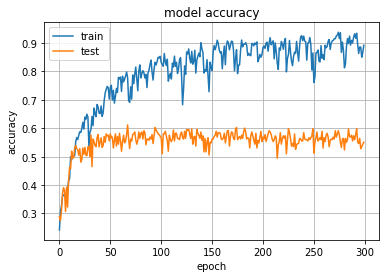

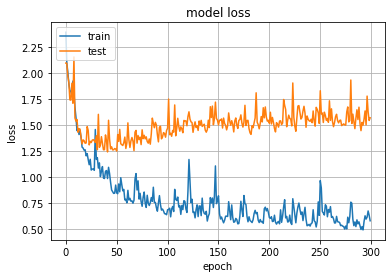

In [7]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [8]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 11672), started 2:51:10 ago. (Use '!kill 11672' to kill it.)